In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy

# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
#         if forwards:
#             b_minus  = self.b_backward(self.theta_b, Xt)
#             b_plus = self.b_forward(theta, Xt)
#             delta_Xt = b_plus - W
#         else:
#             b_minus  = self.b_backward(theta, Xt)
#             b_plus = self.b_forward(self.theta_f, Xt)
            
#             delta_Xt = (b_minus + W)[:,]

In [3]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
    
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
#     @partial(jit, static_argnums=(0,3))
    def loss_for_trajectory(self, Xt, theta, W, forwards):
        n_, *_ = Xt.shape
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        if forwards:
            b_minus  = self.b_backward(self.theta_b, Xt)
            b_plus = self.b_forward(theta, Xt)
        else:
            b_minus  = self.b_backward(theta, Xt)
            b_plus = self.b_forward(self.theta_f, Xt)

            
        delta_Xt = Xt[:, 1:, :] - Xt[:, :-1, :]  
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, :-1,:] - b_minus[:, 1:,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * self.dt 
        
        out =  ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
        
        if np.isnan(out).any() or np.isinf(out).any():
            import pdb; pdb.set_trace()
        return out

#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(self, theta, batch,  
                       batch_terminal_empirical,
                       H,  forwards):
        
        b = (
            self.b_forward if forwards else (lambda X, theta: -self.b_backward(X, theta))
        )
        
        t, Xt, *W = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, X0=batch,
            N= self.number_time_steps, theta=theta
        )
        
        cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
        main_term = self.loss_for_trajectory(Xt, theta, W, forwards)
        
        if np.isnan(cross_entropy).any() or np.isnan(main_term).any():
            import pdb; pdb.set_trace()

        J = np.mean(main_term + cross_entropy )
        J = np.squeeze(J)
        return J
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            theta, batch,
            batch_terminal_empirical, H ,  forwards
        )

#     @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        for i in tqdm(range(IPFP_iterations)):

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params_b = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params_b, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.theta_b = params_b

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), True
                    )
                params_f = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params_f, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.theta_f = params_f

            self.loss_f = loss_f
            self.loss_b = loss_b

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

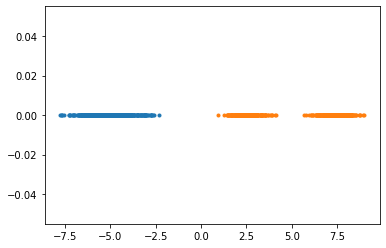

In [4]:
n = 500
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 5
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 7.5
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) + 2.5
X2 = np.concatenate((X21, X22), axis=0)

X1 , X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [5]:
c = cIPFP(X1, X2,  number_time_steps=100, batch_size=500 , step_size = 0.001, weights=[50,50,50,50])

In [ ]:
c.fit(59,30)

loss b 65.32339477539062
loss b 63.50503158569336
loss b 60.00080871582031
loss b 56.17692947387695
loss b 55.403358459472656
loss b 52.405086517333984
loss b 50.779449462890625
loss b 48.757850646972656
loss b 46.77981948852539
loss b 44.48551559448242
loss b 42.794193267822266
loss b 40.52231979370117
loss b 38.914039611816406
loss b 37.12665557861328
loss b 35.06671905517578
loss b 32.870933532714844
loss b 32.1874885559082
loss b 31.171459197998047
loss b 28.76395034790039
loss b 27.309045791625977
loss b 27.082992553710938
loss b 25.700485229492188
loss b 24.765823364257812
loss b 24.529850006103516
loss b 23.66672134399414
loss b 22.99176025390625
loss b 22.63353157043457
loss b 22.5262393951416
loss b 22.314584732055664
loss b 22.13701057434082
loss f 515.3014526367188
loss f 484.1934814453125
loss f 460.5285339355469
loss f 436.2093505859375
loss f 413.92767333984375
loss f 384.0631408691406
loss f 372.035400390625
loss f 351.13287353515625
loss f 338.29925537109375
loss f 318.

loss b 1.127915859222412
loss b 2.1267426013946533
loss b 1.646198034286499
loss b 1.9714967012405396
loss b 1.7099237442016602
loss f 6.3879289627075195
loss f 5.994058132171631
loss f 6.310303211212158
loss f 6.036924839019775
loss f 5.871070384979248
loss f 5.908807277679443
loss f 6.736605167388916
loss f 6.208800792694092
loss f 6.40804386138916
loss f 6.280648708343506
loss f 6.1091766357421875
loss f 5.9661688804626465
loss f 6.248733997344971
loss f 5.687911033630371
loss f 5.89581298828125
loss f 6.335680961608887
loss f 6.2972846031188965
loss f 6.190664768218994
loss f 6.006446838378906
loss f 6.603696823120117
loss f 5.768603801727295
loss f 5.759553909301758
loss f 5.798411846160889
loss f 5.701690673828125
loss f 5.773334980010986
loss f 5.693150520324707
loss f 6.364974498748779
loss f 5.561871528625488
loss f 6.266205787658691
loss f 5.838015556335449
loss b 3.484992027282715
loss b 1.44537353515625
loss b 1.816752552986145
loss b 1.0603431463241577
loss b 2.98945498466

loss f 4.608601093292236
loss f 4.589444160461426
loss f 4.751076698303223
loss f 4.442038536071777
loss f 4.540517807006836
loss f 4.950685501098633
loss f 4.581890106201172
loss f 4.649874210357666
loss f 4.488614082336426
loss f 4.774601459503174
loss f 4.655600547790527
loss b 0.6966415047645569
loss b 0.7445935606956482
loss b 1.3770109415054321
loss b 1.3573429584503174
loss b 1.0177414417266846
loss b 1.4724887609481812
loss b 0.9259872436523438
loss b 1.061437964439392
loss b 1.3597650527954102
loss b 1.1369140148162842
loss b 2.0583419799804688
loss b 1.0132390260696411
loss b 1.490447998046875
loss b 1.1525236368179321
loss b 0.9073046445846558
loss b 1.0936976671218872
loss b 1.2251344919204712
loss b 1.2975980043411255
loss b 1.096235752105713
loss b 1.1266549825668335
loss b 1.0455050468444824
loss b 0.7563759088516235
loss b 0.7451817989349365
loss b 1.0709290504455566
loss b 1.5048965215682983
loss b 0.5444785356521606
loss b 1.368273138999939
loss b 1.339821696281433
lo

loss b 0.7712332606315613
loss b 1.1397267580032349
loss b 0.3679940402507782
loss b 0.9180276393890381
loss b 1.5821499824523926
loss b 0.5676682591438293
loss b 0.8594200015068054
loss b 1.0174716711044312
loss b 0.7384653091430664
loss b 0.7984933853149414
loss b 0.6142445802688599
loss b 0.6832191348075867
loss b 0.9860867261886597
loss b 0.6871023774147034
loss b 0.8029068112373352
loss b 1.26302170753479
loss b 0.9589833617210388
loss b 0.548987090587616
loss b 0.9533966779708862
loss f 4.24217414855957
loss f 3.8837454319000244
loss f 3.863189458847046
loss f 4.181873321533203
loss f 3.7697904109954834
loss f 3.8049838542938232
loss f 4.121753692626953
loss f 3.939819574356079
loss f 3.6749958992004395
loss f 3.661679744720459
loss f 3.8915457725524902
loss f 3.889875650405884
loss f 3.8153419494628906
loss f 4.1031999588012695
loss f 3.8691909313201904
loss f 3.955845594406128
loss f 3.949070692062378
loss f 4.12599515914917
loss f 3.7374610900878906
loss f 3.8044559955596924
l

loss f 3.448695659637451
loss f 3.639901638031006
loss f 3.5010788440704346
loss f 3.5587546825408936
loss f 3.5979185104370117
loss f 3.773159980773926
loss f 3.5740599632263184
loss f 3.586888313293457
loss f 3.3944575786590576
loss f 3.613964557647705
loss f 3.4607183933258057
loss f 3.7045514583587646
loss f 3.571044445037842
loss f 3.643134355545044
loss f 3.6314425468444824
loss f 3.6928794384002686
loss f 3.8093464374542236
loss f 3.43508243560791
loss f 3.5282673835754395
loss f 3.387545347213745
loss f 3.589693546295166
loss f 3.5020275115966797
loss f 3.708385705947876
loss f 3.6302924156188965
loss f 3.706113576889038
loss f 3.414187431335449
loss f 3.5316355228424072
loss f 3.492988109588623
loss f 3.504180908203125
loss f 3.503206491470337
loss b 0.8128036260604858
loss b 0.5549991130828857
loss b 0.702255129814148
loss b 1.0127536058425903
loss b 0.46733370423316956
loss b 0.7162818908691406
loss b 0.6199504137039185
loss b 0.4873957931995392
loss b 0.727880597114563
loss

loss f 3.1493918895721436
loss f 3.391352415084839
loss f 3.3416802883148193
loss f 3.3201847076416016
loss f 3.138012409210205
loss f 3.338205099105835
loss f 3.2503206729888916
loss f 3.3204073905944824
loss f 3.214791774749756
loss f 3.3735527992248535
loss f 3.233468532562256
loss b 0.768122136592865
loss b 0.9600740671157837
loss b 0.8648298978805542
loss b 0.6629090905189514
loss b 0.8959334492683411
loss b 0.5291770100593567
loss b 0.7961272597312927
loss b 0.5728759765625
loss b 0.7186239361763
loss b 0.5016972422599792
loss b 0.5369846224784851
loss b 0.5304450392723083
loss b 0.5980888605117798
loss b 0.6089723706245422
loss b 0.4487757980823517
loss b 0.5151770114898682
loss b 0.35965776443481445
loss b 0.21687409281730652
loss b 0.4779689610004425
loss b 0.8073496222496033
loss b 0.29700177907943726
loss b 0.6441893577575684
loss b 0.2893923223018646
loss b 0.4245532155036926
loss b 0.6438522338867188
loss b 0.34448888897895813
loss b 0.9151816964149475
loss b 0.49837145209

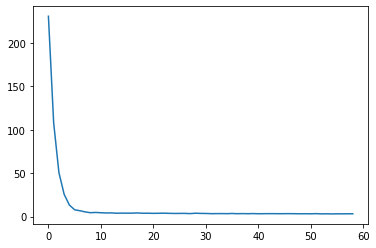

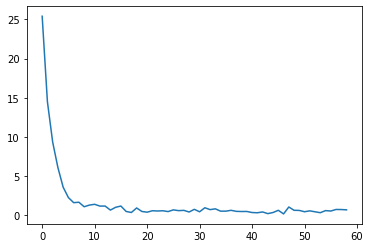

In [31]:
plt.plot(c.loss_f)
plt.show()
plt.plot(c.loss_b)

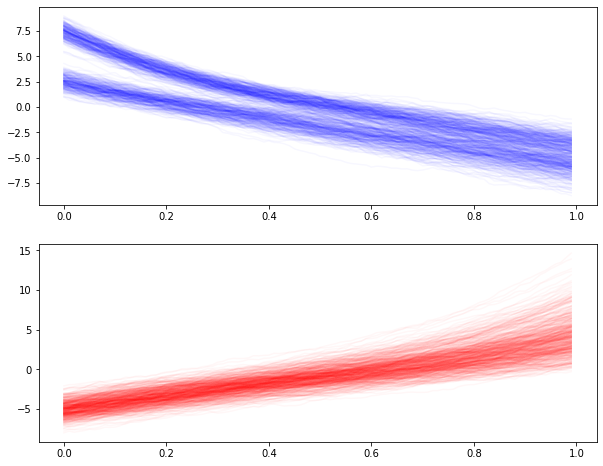

In [32]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
t, Xts = c.sde_solver(X0=X1,dt=c.dt,  theta=c.theta_f,  beta=c.sigma, alfa=c.b_forward, N=c.number_time_steps)
for i in range(n):
    
    axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03, )

t_, Xts_ = c.sde_solver(X0=X2, dt=c.dt,  theta=c.theta_b,  beta=c.sigma, alfa=bb, N=c.number_time_steps)
for i in range(n):
    
    axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03)


In [20]:
c.fit(1000,1)

loss b 797.3944091796875
loss f 254.65135192871094
loss b 688.3958740234375
loss f 262.7439270019531
loss b 637.13232421875
loss f 208.0511474609375
loss b 428.5206604003906
loss f 193.8119659423828
loss b 445.2804870605469
loss f 177.5654754638672
loss b 302.061767578125
loss f 117.4031753540039
loss b 236.82510375976562
loss f 100.47130584716797
loss b 220.96926879882812
loss f 111.99282836914062
loss b 183.51434326171875
loss f 110.82113647460938
loss b 140.87353515625
loss f 95.46033477783203
loss b 123.52377319335938
loss f 85.54188537597656
loss b 131.88832092285156
loss f 54.655269622802734
loss b 132.2649688720703
loss f 67.73436737060547
loss b 106.55437469482422
loss f 67.5351791381836
loss b 72.49137878417969
loss f 35.28685760498047
loss b 61.752418518066406
loss f 34.02141189575195
loss b 81.23442077636719
loss f 50.714420318603516
loss b 49.58605194091797
loss f 33.243865966796875
loss b 72.89261627197266
loss f 29.693157196044922
loss b 33.14217758178711
loss f 28.197631

loss f 1.4898042678833008
loss b 2.798368453979492
loss f 1.3275052309036255
loss b 2.189592123031616
loss f 2.5680272579193115
loss b 2.500375509262085
loss f 1.3608750104904175
loss b 3.0790398120880127
loss f 1.1528431177139282
loss b 3.4673242568969727
loss f 1.1201080083847046
loss b 2.4702839851379395
loss f 1.3791943788528442
loss b 3.1263585090637207
loss f 1.272571086883545
loss b 3.297498941421509
loss f 1.9041999578475952
loss b 2.1854450702667236
loss f 1.149489164352417
loss b 2.511399507522583
loss f 1.977981448173523
loss b 2.2231767177581787
loss f 1.2241791486740112
loss b 2.301378011703491
loss f 1.194790005683899
loss b 2.5126094818115234
loss f 1.5403633117675781
loss b 2.0171725749969482
loss f 1.3780304193496704
loss b 2.5016865730285645
loss f 1.3575379848480225
loss b 1.949891209602356
loss f 1.27422297000885
loss b 2.452730178833008
loss f 1.1136201620101929
loss b 2.2196578979492188
loss f 1.0903984308242798
loss b 2.430859327316284
loss f 1.578688621520996
lo

loss f 0.7548605799674988
loss b 2.0707998275756836
loss f 1.2008706331253052
loss b 2.374445676803589
loss f 1.1980352401733398
loss b 1.7434791326522827
loss f 0.5509815216064453
loss b 2.0060296058654785
loss f 1.3349800109863281
loss b 2.038029909133911
loss f 0.9607506990432739
loss b 2.072429656982422
loss f 0.4097982347011566
loss b 2.3271868228912354
loss f 1.0057196617126465
loss b 1.608870029449463
loss f 0.9758898615837097
loss b 1.941023826599121
loss f 0.7893505692481995
loss b 2.5759568214416504
loss f 1.1619746685028076
loss b 1.9519474506378174
loss f 0.6381783485412598
loss b 1.8441706895828247
loss f 0.6855630278587341
loss b 2.1085283756256104
loss f 1.5558874607086182
loss b 2.3481709957122803
loss f 0.6715368032455444
loss b 1.7638438940048218
loss f 0.8506651520729065
loss b 2.398674964904785
loss f 2.0107274055480957
loss b 1.8357908725738525
loss f 0.6737675070762634
loss b 1.615014672279358
loss f 1.0149468183517456
loss b 2.5261738300323486
loss f 0.7811451554

KeyboardInterrupt: 

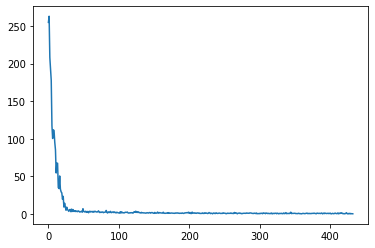

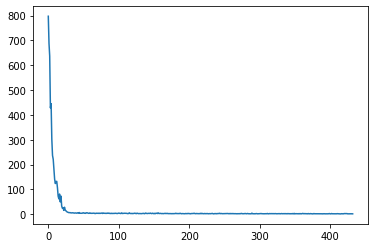

In [21]:
plt.plot(c.loss_f)
plt.show()
plt.plot(c.loss_b)

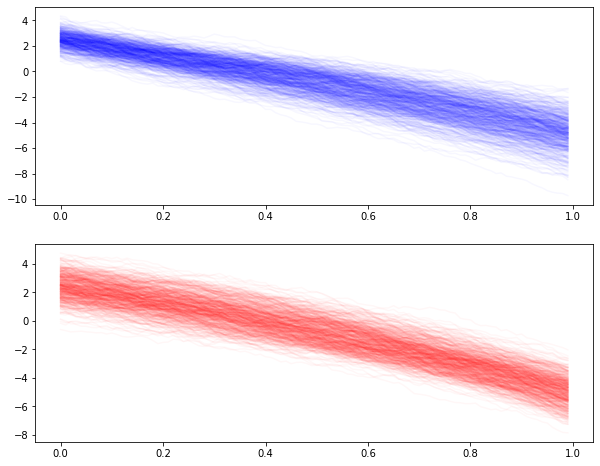

In [23]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
t, Xts = c.sde_solver(X0=X1,dt=c.dt,  theta=c.theta_f,  beta=c.sigma, alfa=c.b_forward, N=c.number_time_steps)
for i in range(n):
    
    axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03, )
BXt = []   

t_, Xts_ = c.sde_solver(X0=X2, dt=c.dt,  theta=c.theta_b,  beta=c.sigma, alfa=bb, N=c.number_time_steps)
for i in range(n):
    
#     BXt.append(Xt_[-1,:])
    axs[1].plot(t_.flatten(), Xts_[i,...].flatten()[::-1], 'r', alpha=0.03)


In [33]:
X22 = np.array(c.transport_batch( X1, True)).flatten()

In [34]:
X11 = np.array(c.transport_batch(X2, False)).flatten()

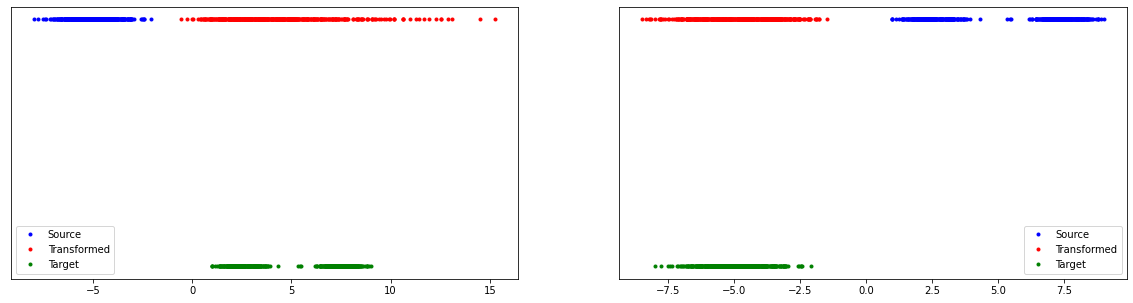

In [35]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(X2.flatten(), [0] * n, 'b.', label="Source")
axs[0].plot(X11, [0] * n, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * n, 'b.', label="Source")
axs[1].plot(X22, [0] * n, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend()

In [155]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

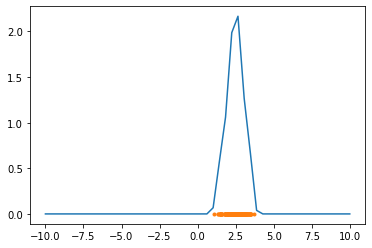

In [156]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [157]:
batch_terminal_empirical_b = next(c.data_stream(False))

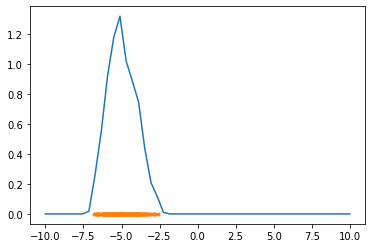

In [158]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")